In [3]:
import sympy as sp
from sympy import diff, sin, cos, exp, sqrt, Rational, Matrix
from quantum_electron import package_versions

import numpy as np
from matplotlib import pyplot as plt
from scipy.constants import electron_mass, elementary_charge

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['font.family'] = 'Arial'

save_opts = {"bbox_inches" : "tight", 
             "transparent" : True, 
             "pad_inches" : 0.05}

package_versions()

quantum_electron 0.2.1
numpy 1.25.2
scipy 1.9.3
matplotlib 3.5.3


# Calculation of the electron capacitance

In this section, we calculate an analytical expression for the electron eigenfrequencies. These expressions are used to find the capacitance of a single electron. We'll start with the eigensystem for a single electron moving in the 1D plane coupled to an LC resonator. 

In [4]:
me, e, L, C, alpha, alpha2, omega0, omegae = sp.symbols('m_e e L C α α_2 ω_0, ω_e')

The matrix equation that describes the equations of motion is given by 
$$
\omega^2 [\mathbf{M}] \vec{q} = [\mathbf{K}] \vec{q},
$$
and therefore, the eigenvalues of the matrix $[\mathbf{M}]^{-1}[\mathbf{K}]$ are the squared eigenfrequencies $\omega^2$.

In [5]:
MinvK = Matrix([[1 / (L * C), e * alpha / (L * C)], 
            [e * alpha / (me * C), omegae ** 2]])

In [6]:
evals = MinvK.eigenvals()

Since it's a 2x2 matrix, there are 2 eigenvalues. Let's take a look at the first eigenvalue

In [7]:
list(evals.keys())[0].subs(L, 1/(omega0**2 * C)).simplify()

(m_e*ω_0**2 + m_e*ω_e**2 - ω_0**2*sqrt(m_e*(m_e - 2*m_e*ω_e**2/ω_0**2 + m_e*ω_e**4/ω_0**4 + 4*e**2*α**2/(C*ω_0**2))))/(2*m_e)

The second eigenvalue is similar in structure

In [8]:
list(evals.keys())[1].subs(L, 1/(omega0**2 * C)).simplify()

(m_e*ω_0**2 + m_e*ω_e**2 + ω_0**2*sqrt(m_e*(m_e - 2*m_e*ω_e**2/ω_0**2 + m_e*ω_e**4/ω_0**4 + 4*e**2*α**2/(C*ω_0**2))))/(2*m_e)

Next, we may expand these eigenvalues small values of $\omega_e / \omega_0$ to arrive at the expression for the electron capacitance.

# Coupled oscillators

In the previous section, we studied the simple LC model and its eigenfrequencies. However, our resonator more closely resembles two coupled LC resonators with a coupling capacitance $C_\mathrm{dot}$. In this section, we'll study that model and see if we can derive similar analytical expressions for the eigenfrequencies.

In [9]:
me, e, L, C1, C2, Cdot, D = sp.symbols('m_e e L C_1 C_2 C_dot D', positive=True)
alpha_a, alpha_b, Vxx = sp.symbols('α_a α_b V_xx')
omega0, omegae = sp.symbols('ω_0 ω_e', positive=True)


## Single electron

Again, we're setting up the equations of motion in matrix form: $
\omega^2 [\mathbf{M}] \vec{q} = [\mathbf{K}] \vec{q}
$.
For the coupled LC resonators, there are 2 resonator indices, and 1 electron index, such that the matrix becomes a 3x3 matrix. 

In [10]:
M = Matrix([[L, 0, 0], 
            [0, L, 0], 
            [0, 0, me]])

M.inv()

Matrix([
[1/L,   0,     0],
[  0, 1/L,     0],
[  0,   0, 1/m_e]])

In [11]:
K = Matrix([[(C2 + Cdot)/D, Cdot / D, e * alpha_a / D], 
            [Cdot / D, (C1 + Cdot) / D, e * alpha_b / D], 
            [e * alpha_a / D, e * alpha_b / D, e * Vxx]])

K

Matrix([
[(C_2 + C_dot)/D,         C_dot/D, e*α_a/D],
[        C_dot/D, (C_1 + C_dot)/D, e*α_b/D],
[        e*α_a/D,         e*α_b/D,  V_xx*e]])

In [12]:
MinvK = M.inv() * K
MinvK

Matrix([
[(C_2 + C_dot)/(D*L),         C_dot/(D*L), e*α_a/(D*L)],
[        C_dot/(D*L), (C_1 + C_dot)/(D*L), e*α_b/(D*L)],
[      e*α_a/(D*m_e),       e*α_b/(D*m_e),  V_xx*e/m_e]])

We know that $$V_{xx} = \frac{\partial^2 V}{\partial x^2}$$ is related to the bare electron frequency as follows:

$$
\omega^2 = \frac{e}{m_e} \frac{\partial^2 V}{\partial x^2}
$$

Therefore, we can substitute for $\omega_e$ in the lower right corner of the matrix:

In [13]:
MinvK[2, 2] = omegae**2
MinvK

Matrix([
[(C_2 + C_dot)/(D*L),         C_dot/(D*L), e*α_a/(D*L)],
[        C_dot/(D*L), (C_1 + C_dot)/(D*L), e*α_b/(D*L)],
[      e*α_a/(D*m_e),       e*α_b/(D*m_e),      ω_e**2]])

In [14]:
evals = MinvK.subs(C1, C).subs(C2, C).eigenvals()

Unfortunately for us, the eigenvalues don't look as appetizing as in the simple LC oscillator case. Therefore, we shall resort to numerical modeling.

In [15]:
list(evals.keys())[0].subs(C1, C).subs(C2, C).simplify()

(2*m_e**(11/6)*(2*C + 2*C_dot + D*L*ω_e**2)*(27*L*m_e**(9/2)*(-C**2*D*m_e*ω_e**2 - 2*C*C_dot*D*m_e*ω_e**2 + C*e**2*α_a**2 + C*e**2*α_b**2 + C_dot*e**2*α_a**2 - 2*C_dot*e**2*α_a*α_b + C_dot*e**2*α_b**2) - 2*m_e**(11/2)*(2*C + 2*C_dot + D*L*ω_e**2)**3 + 9*m_e**(9/2)*(2*C + 2*C_dot + D*L*ω_e**2)*(C**2*m_e + 2*C*C_dot*m_e + 2*C*D*L*m_e*ω_e**2 + 2*C_dot*D*L*m_e*ω_e**2 - L*e**2*α_a**2 - L*e**2*α_b**2) + m_e**4*sqrt(m_e*(27*L*(-C**2*D*m_e*ω_e**2 - 2*C*C_dot*D*m_e*ω_e**2 + C*e**2*α_a**2 + C*e**2*α_b**2 + C_dot*e**2*α_a**2 - 2*C_dot*e**2*α_a*α_b + C_dot*e**2*α_b**2) - 2*m_e*(2*C + 2*C_dot + D*L*ω_e**2)**3 + 9*(2*C + 2*C_dot + D*L*ω_e**2)*(C**2*m_e + 2*C*C_dot*m_e + 2*C*D*L*m_e*ω_e**2 + 2*C_dot*D*L*m_e*ω_e**2 - L*e**2*α_a**2 - L*e**2*α_b**2))**2 - 4*(-3*C**2*m_e - 6*C*C_dot*m_e - 6*C*D*L*m_e*ω_e**2 - 6*C_dot*D*L*m_e*ω_e**2 + 3*L*e**2*α_a**2 + 3*L*e**2*α_b**2 + m_e*(2*C + 2*C_dot + D*L*ω_e**2)**2)**3))**(1/3) + 2*2**(1/3)*m_e**(8/3)*(3*C**2*m_e + 6*C*C_dot*m_e + 6*C*D*L*m_e*ω_e**2 + 6*C_dot*D*L*m

## Two electrons

For two electrons the matrix becomes a 4x4 matrix: 2 cavity and 2 electron coordinates.

In [16]:
M = Matrix([[L, 0, 0, 0], 
            [0, L, 0, 0], 
            [0, 0, me, 0],
            [0, 0, 0, me]])

M.inv()

Matrix([
[1/L,   0,     0,     0],
[  0, 1/L,     0,     0],
[  0,   0, 1/m_e,     0],
[  0,   0,     0, 1/m_e]])

For a harmonic potential, the electron separation can be expressed in terms of the trap curvature:

$$
    r_{12}^3 = \frac{e^2}{2\pi \epsilon_0 m_e \omega_\mathrm{trap}^2}
$$
and therefore 
$$
    k_{12}^+ = \frac{e^2}{4\pi\epsilon_0} \frac{1}{r_{12}^3} = \frac{m_e \omega_\mathrm{trap}^2}{2}
$$
In addition, for pure parabolic confinement, both electrons have the same frequency set by $\omega_\mathrm{trap}^2$.

In [17]:
K = Matrix([[(C2 + Cdot)/D, Cdot / D, e * alpha_a / D, e * alpha_a / D], 
            [Cdot / D, (C1 + Cdot) / D, e * alpha_b / D, e * alpha_b / D], 
            [e * alpha_a / D, e * alpha_b / D, 3/2 * me * omegae ** 2, -1/2 * me * omegae**2], 
            [e * alpha_a / D, e * alpha_b / D, -1/2 * me * omegae**2, 3/2 * me * omegae**2]])

K

Matrix([
[(C_2 + C_dot)/D,         C_dot/D,         e*α_a/D,         e*α_a/D],
[        C_dot/D, (C_1 + C_dot)/D,         e*α_b/D,         e*α_b/D],
[        e*α_a/D,         e*α_b/D,  1.5*m_e*ω_e**2, -0.5*m_e*ω_e**2],
[        e*α_a/D,         e*α_b/D, -0.5*m_e*ω_e**2,  1.5*m_e*ω_e**2]])

In [18]:
MinvK = M.inv() * K
MinvK

Matrix([
[(C_2 + C_dot)/(D*L),         C_dot/(D*L), e*α_a/(D*L), e*α_a/(D*L)],
[        C_dot/(D*L), (C_1 + C_dot)/(D*L), e*α_b/(D*L), e*α_b/(D*L)],
[      e*α_a/(D*m_e),       e*α_b/(D*m_e),  1.5*ω_e**2, -0.5*ω_e**2],
[      e*α_a/(D*m_e),       e*α_b/(D*m_e), -0.5*ω_e**2,  1.5*ω_e**2]])

## Eigenfrequencies without the electron

To verify the eigenfrequencies of the coupled model we briefly eliminate the electron from the matrix, and calculate the eigenvalues:

In [19]:
evals = MinvK[:2, :2].eigenvals()

We find that $\omega_\mathrm{diff}^2$ is given by

In [20]:
list(evals.keys())[0].subs(C1, C).subs(C2, C).subs(D, C**2 + 2*C*Cdot).simplify()

1/(L*(C + 2*C_dot))

and similarly $\omega_\mathrm{comm}^2$ is given by

In [21]:
list(evals.keys())[1].subs(C1, C).subs(C2, C).subs(D, C**2 + 2*C*Cdot).simplify()

1/(C*L)

### With an inductive tail to ground

When adding an inductive tail, one can also split the common and differential mode frequencies. Using the $Y-\Delta$ transform the circuit can be transformed to the same circuit but with an extra inductive shunt $L_c$. In addition, $L_a$ and $L_b$ are linear combinations of physical inductors $L_1, L_2$ and $L_g$

In [22]:
La, Lb, Lc, Lg= sp.symbols('L_a L_b L_c L_g', real=True, positive=True)

Cinv = Matrix([[(C2 + Cdot)/D, Cdot / D], 
                [Cdot / D, (C1 + Cdot) / D]])

Linv = Matrix([[1/Lb + 1/Lc, -1/Lc], 
               [-1/Lc, 1/La + 1/Lc]])

evals_tail = (Cinv*Linv).eigenvals()
list(evals_tail.keys())[1].subs(La, L+2*Lg).subs(Lb, L + 2*Lg).subs(Lc, L*(2 + L/Lg)).subs(C1, C).subs(C2, C).subs(D, C**2 + 2*C*Cdot).simplify()

(C*L + C*L_g + C_dot*L + sqrt(C**2*L_g**2 - 2*C*C_dot*L*L_g + C_dot**2*L**2))/(C*L*(C + 2*C_dot)*(L + 2*L_g))

In [23]:
list(evals_tail.keys())[0].subs(La, L+2*Lg).subs(Lb, L + 2*Lg).subs(Lc, L*(2 + L/Lg)).subs(C1, C).subs(C2, C).subs(D, C**2 + 2*C*Cdot).simplify()

(C*L + C*L_g + C_dot*L - sqrt(C**2*L_g**2 - 2*C*C_dot*L*L_g + C_dot**2*L**2))/(C*L*(C + 2*C_dot)*(L + 2*L_g))

## Numerical explorations of the coupled LC oscillator model

We'll use some of the expressions derived above in this section, so please refer to those sections, in particular for the derivation of the matrix $[\mathbf{M}]^{-1}[\mathbf{K}]$.
The following function will allow us to diagonalize this matrix to find the eigenfrequencies. 

In [84]:
def single_e_system(c, cdot, l, omega_trap, alpha_plus_prime, alpha_minus_prime):
    c1 = c
    c2 = c
    d = c1 * c2 + cdot * c1 + c2 * cdot

    alpha_a = (c2 + cdot) * alpha_plus_prime + cdot * alpha_minus_prime
    alpha_b = (c1 + cdot) * alpha_minus_prime + cdot * alpha_plus_prime
    
    minvk = np.array([[(c2 + cdot) / (d * l), cdot / (d * l), elementary_charge * alpha_a / (d * l)], 
                      [cdot / (d * l), (c1 + cdot) / (d * l), elementary_charge * alpha_b / (d * l)], 
                      [elementary_charge * alpha_a / (d * electron_mass), elementary_charge * alpha_b / (d * electron_mass), omega_trap ** 2]])
    
    evals, evecs = np.linalg.eig(minvk)
    efreqs = np.sqrt(evals) / (2 * np.pi )
    
    return efreqs

def single_e_with_tail(L, Ltail, Ca, Cb, Cs, omega_trap, alpha_a_prime, alpha_b_prime):
    """
    This is only valid if the tail inductance is non-zero
    This method is prefered over the analytical expression, because if the tail is non-zero and the 
    capacitances are asymmetric, the expression becomes very lengthy. Diagonalizing the hamiltonian numerically
    is slightly better.
    """
    L1 = L + 2*Ltail
    L2 = L1
    L3 = L * (L + 2 * Ltail) / Ltail

    D = Ca * Cb + Cs * Ca + Cb * Cs
    beta_a = (Cb + Cs) / D * alpha_a_prime + Cs / D * alpha_b_prime
    beta_b = (Ca + Cs) / D * alpha_b_prime + Cs / D * alpha_a_prime

    Cinv = np.array([[(Cb + Cs) / D, Cs / D, elementary_charge * beta_a], 
                  [Cs / D, (Ca + Cs) / D, elementary_charge * beta_b], 
                  [elementary_charge * beta_a, elementary_charge * beta_b, electron_mass * omega_trap ** 2]])
    
    Linv = np.array([[1 / L2 + 1 / L3,  -1/L3, 0],
                     [-1/L3, 1/L1 + 1/L3, 0], 
                     [0, 0, 1 / electron_mass]])

    evals, evecs = np.linalg.eig(Linv @ Cinv)
    
    return np.sqrt(np.real(evals)) / (2 * np.pi), evecs

def double_e_system(c, cdot, l, omega_trap, alpha_plus_prime, alpha_minus_prime):
    c1 = c
    c2 = c
    d = c1 * c2 + cdot * c1 + c2 * cdot

    alpha_a = (c2 + cdot) * alpha_plus_prime + cdot * alpha_minus_prime
    alpha_b = (c1 + cdot) * alpha_minus_prime + cdot * alpha_plus_prime
    
    minvk = np.array([[(c2 + cdot) / (d * l), cdot / (d * l), elementary_charge * alpha_a / (d * l), elementary_charge * alpha_a / (d * l)], 
                      [cdot / (d * l), (c1 + cdot) / (d * l), elementary_charge * alpha_b / (d * l), elementary_charge * alpha_b / (d * l)], 
                      [elementary_charge * alpha_a / (d * electron_mass), elementary_charge * alpha_b / (d * electron_mass), 3/2*omega_trap ** 2, -1/2*omega_trap ** 2], 
                      [elementary_charge * alpha_a / (d * electron_mass), elementary_charge * alpha_b / (d * electron_mass), -1/2*omega_trap ** 2, 3/2*omega_trap ** 2]])
    
    evals, evecs = np.linalg.eig(minvk)
    efreqs = np.sqrt(evals) / (2 * np.pi )
    
    return efreqs

def double_e_with_tail(L, Ltail, Ca, Cb, Cs, omega_trap, alpha_a_prime, alpha_b_prime):
    """
    This is only valid if the tail inductance is non-zero
    This method is prefered over the analytical expression, because if the tail is non-zero and the 
    capacitances are asymmetric, the expression becomes very lengthy. Diagonalizing the hamiltonian numerically
    is slightly better.
    """
    L1 = L + 2*Ltail
    L2 = L1
    L3 = L * (L + 2 * Ltail) / Ltail

    D = Ca * Cb + Cs * Ca + Cb * Cs
    beta_a = (Cb + Cs) / D * alpha_a_prime + Cs / D * alpha_b_prime
    beta_b = (Ca + Cs) / D * alpha_b_prime + Cs / D * alpha_a_prime

    Cinv = np.array([[(Cb + Cs) / D, Cs / D, elementary_charge * beta_a, elementary_charge * beta_a], 
                     [Cs / D, (Ca + Cs) / D, elementary_charge * beta_b, elementary_charge * beta_b], 
                     [elementary_charge * beta_a, elementary_charge * beta_b, 3/2*electron_mass*omega_trap ** 2, -1/2*electron_mass*omega_trap ** 2], 
                     [elementary_charge * beta_a, elementary_charge * beta_b, -1/2*electron_mass*omega_trap ** 2, 3/2*electron_mass*omega_trap ** 2]])
    
    Linv = np.array([[1 / L2 + 1 / L3,  -1/L3, 0, 0],
                     [-1/L3, 1/L1 + 1/L3, 0, 0], 
                     [0, 0, 1 / electron_mass, 0], 
                     [0, 0, 0, 1 / electron_mass]])

    evals, evecs = np.linalg.eig(Linv @ Cinv)
    
    return np.sqrt(np.real(evals)) / (2 * np.pi), evecs

In [85]:
MinvK

Matrix([
[(C_2 + C_dot)/(D*L),         C_dot/(D*L), e*α_a/(D*L), e*α_a/(D*L)],
[        C_dot/(D*L), (C_1 + C_dot)/(D*L), e*α_b/(D*L), e*α_b/(D*L)],
[      e*α_a/(D*m_e),       e*α_b/(D*m_e),  1.5*ω_e**2, -0.5*ω_e**2],
[      e*α_a/(D*m_e),       e*α_b/(D*m_e), -0.5*ω_e**2,  1.5*ω_e**2]])

A quick example of how to use this. Let's say experimentally we have a resonator with measured differential frequency `f0_diff` and expected impedance `Z0_diff`. The cell below calculates the inductance and capacitances consistent with these inputs.
Note that `alpha_plus_prime` and `alpha_minus_prime` are $\partial \alpha_\mathrm{res}^a /\partial x$ and $\partial \alpha_\mathrm{res}^b /\partial x$, respectively. These are the values of the electric field when 1 V is applied to the top and bottom electrodes of the resonator, respectively.

In [45]:
params = {"Ca" : 8.80e-15 + 1.27e-15,
          "Cb" : 9.57e-15 + 0.45e-15,
          "Cs" : 0.85e-15, 
          "L" : 64.9e-9,
          "Ltail" : 6.5e-9, 
          "omega_trap" : 2 * np.pi * 20e9, 
          "alpha_a_prime" : 0.2e6, 
          "alpha_b_prime" : -0.2e6}

# efreqs = single_e_system(**params)
efreqs, evecs = single_e_with_tail(**params)
efreqs

array([2.00000110e+10, 5.68896750e+09, 5.76517539e+09])

In [36]:
np.sqrt(params['L'] / (0.5 * (params['Ca'] + params['Cb']) + 2 * params['Cs']))

2350.6925874512326

The common and differential modde frequencies are identified far away from the electron crossings, and they are:

In [41]:
f_comm = np.sqrt(1 / ((params['L'] + 2*params['Ltail']) * 0.5 * (params['Ca'] + params['Cb']))) / (2 * np.pi )
f_diff = np.sqrt(1 / (params['L'] * (0.5 * (params['Ca'] + params['Cb']) + 2 * params['Cs']))) / (2 * np.pi )

print(f"Common mode: {f_comm/1e9:.3f} GHz, Differential mode: {f_diff/1e9:.3f} GHz")

Common mode: 5.690 GHz, Differential mode: 5.765 GHz


## Resonant coupling of a single electron 

Let us check that the model makes sense. First, when `alpha_plus_prime = -alpha_minus_prime`, the electron shouldn't couple to the common mode of the resonator.

2g/2π =  86.6889286530428 MHz


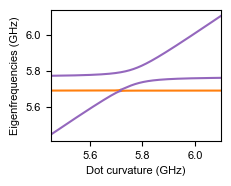

In [126]:
electron_freqs = np.linspace(5.45e9, 6.1e9, 5001)

eigenfrequencies = np.zeros((len(electron_freqs), 2))
common_mode = np.zeros(len(electron_freqs))

fig = plt.figure(figsize=(2.2, 1.7))

for Ex, alph in zip([0.25e6], [1.0]):
    common_mode_idx = list()
    
    params = {"Ca" : 8.80e-15 + 1.27e-15,
              "Cb" : 9.57e-15 + 0.45e-15,
              "Cs" : 0.85e-15, 
              "L" : 64.9e-9,
              "Ltail" : 6.5e-9, 
              "omega_trap" : 2 * np.pi * 20e9, 
              "alpha_a_prime" : Ex, 
              "alpha_b_prime" : -Ex}

    for k, f_e in enumerate(electron_freqs):
        params["omega_trap"] = 2 * np.pi * f_e
        # efreqs = single_e_system(**params)
        efreqs, evecs = single_e_with_tail(**params)

        common_mode_idx = np.argmin(np.abs(efreqs - 5.690e9))
        selection = np.delete(np.arange(3), common_mode_idx)
        eigenfrequencies[k] = np.sort(efreqs[selection])
        
        common_mode[k] = efreqs[common_mode_idx]
        
        # common_mode_idx.append(np.argmin(np.abs(efreqs - 5.69e9)))
        
    plt.plot(electron_freqs / 1e9, common_mode / 1e9, color='tab:orange')
        
    for k in range(2):
        label = "" if k == 0 else f"Ex = {Ex/1e6}V/$\mu$m"
        plt.plot(electron_freqs /1e9, eigenfrequencies[:, k] /1e9, color='tab:purple', alpha=alph, label=label)

    # Estimate 2 * g from the minimum distance.
    print("2g/2π = ", np.min(eigenfrequencies[:, 1] - eigenfrequencies[:, 0]) / 1e6, "MHz")

    plt.xlabel("Dot curvature (GHz)")
    plt.ylabel("Eigenfrequencies (GHz)")
    plt.xlim(electron_freqs.min() / 1e9, electron_freqs.max() /1e9)
    # plt.legend(loc=0, frameon=False)

Indeed, we see that the common mode doesn't have an avoided crossing, whereas the differential mode has an avoided crossing that tunes with the value of `alpha_minus_prime`. 

We determined the apparent $g$ from the avoided crossing, but does this value of $g/2\pi$ make sense? For a simple LC circuit we found $g_\mathrm{LC}$, which is given by 

$$
    g_\mathrm{LC} = \frac{1}{2} e E_x \sqrt{\frac{Z}{m_e \omega_e}}
$$

However, for coupling to the differential mode, the coupling is given by

$$
    g_\mathrm{coupled} = \frac{1}{2} e \tilde{E_x} \sqrt{\frac{Z}{m_e \omega_e}}, 
$$

where 

$$
    \tilde{E_x} = \sqrt{2} \left( \frac{1}{2} \frac{\partial \alpha_\mathrm{res}^a}{\partial x} - \frac{1}{2} \frac{\partial \alpha_\mathrm{res}^b}{\partial x} \right)
$$
and therefore $g_\mathrm{coupled} = \sqrt{2} g_\mathrm{LC}$. The $\sqrt{2}$ enhancement of $g$ compared with the simple LC circuit comes from the enhancement in zero-point fluctuations.

In [87]:
for Ex in [0.25e6, 1e6]:
    Ex_tilde = np.sqrt(2) * (Ex - -Ex) / 2
    f0_diff = np.sqrt(1 / (params['L'] * (0.5 * (params['Ca'] + params['Cb']) + 2 * params['Cs']))) / (2 * np.pi)
    Z0_diff = np.sqrt(params['L'] / (0.5 * (params['Ca'] + params['Cb']) + 2 * params['Cs']))
    print(f"For Ex = {Ex/1e6:0.2f} V/µm, we expect 2g/2π = {2 * 1e-6 * 0.5 * elementary_charge * Ex_tilde * np.sqrt(Z0_diff * 2 * np.pi * f0_diff / electron_mass) / (2 * np.pi) : .1f} MHz")

For Ex = 0.25 V/µm, we expect 2g/2π =  87.2 MHz
For Ex = 1.00 V/µm, we expect 2g/2π =  348.6 MHz


## Electron counting in the dispersive regime

To count electrons, we don't have to be resonant with the resonator. Let us calculate the frequency shifts for one and two electrons in the dispersive regime.

In [110]:
params = {"Ca" : 8.80e-15 + 1.27e-15,
          "Cb" : 9.57e-15 + 0.45e-15,
          "Cs" : 0.85e-15, 
          "L" : 64.9e-9,
          "Ltail" : 6.5e-9, 
          "omega_trap" : 2 * np.pi * 100e9, 
          "alpha_a_prime" : Ex, 
          "alpha_b_prime" : -Ex}

# f0_comm = np.sqrt(1 / ((params['L'] + 2*params['Ltail']) * 0.5 * (params['Ca'] + params['Cb']))) / (2 * np.pi )
# f0_diff = np.sqrt(1 / (params['L'] * (0.5 * (params['Ca'] + params['Cb']) + 2 * params['Cs']))) / (2 * np.pi )

efreqs = np.sort(single_e_with_tail(**params)[0])
f0_comm, f0_diff = efreqs[:2] 

print(f"Common mode: {f0_comm/1e9:.3f} GHz, Differential mode: {f0_diff/1e9:.3f} GHz")

Common mode: 5.689 GHz, Differential mode: 5.765 GHz


We compare the results of the diagonalization with the shift for a simple LC circuit.

For $n=1$ this shift is given by $\Delta f = g^2 / \Delta$, where we have to take the appropriate $g = g_\mathrm{coupled} = \sqrt{2} g_\mathrm{LC}$. Alternatively, we can rewrite this dispersive shift in a capacitance change as 

$$
    \delta C = \frac{e^2}{m_e (\omega_e^2 - \omega_0^2)} \tilde{E}_x^2
$$
where consistent with the previous section we have
$$
    \tilde{E_x} = \sqrt{2} \left( \frac{1}{2} \frac{\partial \alpha_\mathrm{res}^a}{\partial x} - \frac{1}{2} \frac{\partial \alpha_\mathrm{res}^b}{\partial x} \right).
$$

For two electrons in the dot, the frequency shift is twice as large.

Text(0, 0.5, 'Frequency shift (MHz)')

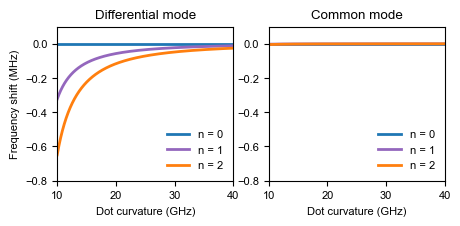

In [121]:
trap_curvatures = np.linspace(10e9, 40e9, 5001)

# Mark here the order of the common mode and differential mode
diff_mode_idx = 1
comm_mode_idx = 0

eigenfrequencies_single_e = np.zeros((len(trap_curvatures), 3))
eigenfrequencies_double_e = np.zeros((len(trap_curvatures), 4))

# Sweep the electron frequency
for k, f_e in enumerate(trap_curvatures):
    params["omega_trap"] = 2 * np.pi * f_e
    eigenfrequencies_single_e[k] = np.sort(single_e_with_tail(**params)[0])
    eigenfrequencies_double_e[k] = np.sort(double_e_with_tail(**params)[0])

fig, ax = plt.subplots(1, 2, figsize=(5, 2))

# And from here we calculate the frequency shifts (measured from the bare values)
ax[0].axhline(0, linestyle='-', lw=2, color='tab:blue', label='n = 0')
ax[0].plot(trap_curvatures/1e9, 1e-6 * (eigenfrequencies_single_e[:, diff_mode_idx] - f0_diff), color='tab:purple', label='n = 1', lw=2)
ax[0].plot(trap_curvatures/1e9, 1e-6 * (eigenfrequencies_double_e[:, diff_mode_idx] - f0_diff), color='tab:orange', label='n = 2', lw=2)
ax[0].set_title("Differential mode")

ax[1].axhline(0, linestyle='-', lw=2, color='tab:blue', label='n = 0')
ax[1].plot(trap_curvatures/1e9, 1e-6 * (eigenfrequencies_single_e[:, comm_mode_idx] - f0_comm), color='tab:purple', label='n = 1', lw=2)
ax[1].plot(trap_curvatures/1e9, 1e-6 * (eigenfrequencies_double_e[:, comm_mode_idx] - f0_comm), color='tab:orange', label='n = 2', lw=2)
ax[1].set_title("Common mode")

# Calculation of the capacitance change from the dispersive shift of the differential mode.
# The expression comes from a simple LC model, but if the resonance frequency shifts agree then this expression should be valid.
total_capacitance = 0.5 * (params['Ca'] + params['Cb']) + 2 * params['Cs']
Ex_tilde = np.sqrt(2) * (0.5 * params['alpha_a_prime'] - 0.5 * params['alpha_b_prime'])
delta_c = elementary_charge ** 2 / (electron_mass * (2 * np.pi) ** 2 * (trap_curvatures ** 2 - f0_diff ** 2)) * Ex_tilde ** 2
simple_lc_shift = -f0_diff * 0.5 * delta_c / total_capacitance

# ax[0].plot(trap_curvatures/1e9, 1e-6* simple_lc_shift, '--', color='black', label="Simple LC circuit")
# ax[0].plot(trap_curvatures/1e9, 2*1e-6* simple_lc_shift, '--', color='black', label="")

for k in [0, 1]:
    ax[k].set_ylim([-0.8, 0.1])
    ax[k].set_xlabel("Dot curvature (GHz)")
    ax[k].set_xlim(trap_curvatures.min()/1e9, trap_curvatures.max()/1e9)
    ax[k].legend(loc=4, frameon=False)

ax[0].set_ylabel("Frequency shift (MHz)")

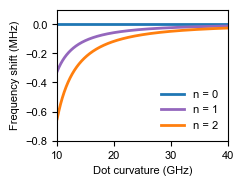

In [125]:
trap_curvatures = np.linspace(10e9, 40e9, 5001)

eigenfrequencies_single_e = np.zeros((len(trap_curvatures), 3))
eigenfrequencies_double_e = np.zeros((len(trap_curvatures), 4))

# Sweep the electron frequency
for k, f_e in enumerate(trap_curvatures):
    params["omega_trap"] = 2 * np.pi * f_e
    eigenfrequencies_single_e[k] = np.sort(single_e_with_tail(**params)[0])
    eigenfrequencies_double_e[k] = np.sort(double_e_with_tail(**params)[0])

fig, ax = plt.subplots(1, 1, figsize=(2.2, 1.7))

# And from here we calculate the frequency shifts (measured from the bare values)
ax.axhline(0, linestyle='-', lw=2, color='tab:blue', label='n = 0')
ax.plot(trap_curvatures/1e9, 1e-6 * (eigenfrequencies_single_e[:, diff_mode_idx] - f0_diff), color='tab:purple', label='n = 1', lw=2)
ax.plot(trap_curvatures/1e9, 1e-6 * (eigenfrequencies_double_e[:, diff_mode_idx] - f0_diff), color='tab:orange', label='n = 2', lw=2)
# ax.set_title("Differential mode")

# Calculation of the capacitance change from the dispersive shift of the differential mode.
# The expression comes from a simple LC model, but if the resonance frequency shifts agree then this expression should be valid.
total_capacitance = 0.5 * (params['Ca'] + params['Cb']) + 2 * params['Cs']
Ex_tilde = np.sqrt(2) * (0.5 * params['alpha_a_prime'] - 0.5 * params['alpha_b_prime'])
delta_c = elementary_charge ** 2 / (electron_mass * (2 * np.pi) ** 2 * (trap_curvatures ** 2 - f0_diff ** 2)) * Ex_tilde ** 2
simple_lc_shift = -f0_diff * 0.5 * delta_c / total_capacitance

# ax.plot(trap_curvatures/1e9, 1e-6* simple_lc_shift, '--', color='black', label="Simple LC circuit")
# ax.plot(trap_curvatures/1e9, 2*1e-6* simple_lc_shift, '--', color='black', label="")

ax.set_ylim([-0.8, 0.1])
ax.set_xlabel("Dot curvature (GHz)")
ax.set_xlim(trap_curvatures.min()/1e9, trap_curvatures.max()/1e9)
ax.legend(loc=4, frameon=False)

ax.set_ylabel("Frequency shift (MHz)")

4500


([<matplotlib.axis.XTick at 0x7f9d1973b580>,
 [Text(0, 0, ''), Text(0, 0, ''), Text(0, 0, '')])

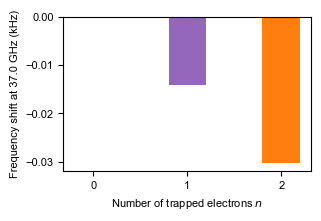

In [123]:
trap_curv_freq = 37e9

print(np.argmin(np.abs(trap_curv_freq - trap_curvatures)))

shifts_kHz = [0, 
              1e-6 * (eigenfrequencies_single_e[np.argmin(np.abs(trap_curv_freq - trap_curvatures)), diff_mode_idx] - f0_diff), 
              1e-6 * (eigenfrequencies_double_e[np.argmin(np.abs(trap_curv_freq - trap_curvatures)), diff_mode_idx] - f0_diff)]
              
plt.figure(figsize=(3.2, 2))
plt.bar(range(3), shifts_kHz, color=['tab:blue', 'tab:purple', 'tab:orange'], width=0.4)
plt.xlabel("Number of trapped electrons $n$")
plt.ylabel(f"Frequency shift at {trap_curv_freq/1e9:.1f} GHz (kHz)")
plt.xticks(range(3))

Here we see that 

- The common mode doesn't couple to the electron(s)
- The differential mode shifts order ~10 kHz
- When the dot capacitance is low, the circuit can be approximated easily by the simple LC circuit. The dot capacitance is only a perturbation in this case.

(10.0, 40.0)

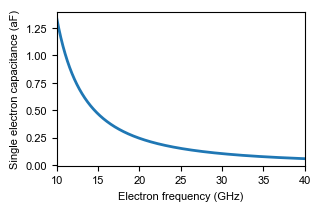

In [124]:
fig = plt.figure(figsize=(3.2,2))
plt.plot(trap_curvatures/1e9, delta_c * 1e18, lw=2)
plt.xlabel("Electron frequency (GHz)")
plt.ylabel("Single electron capacitance (aF)")
plt.xlim(trap_curvatures.min()/1e9, trap_curvatures.max()/1e9)

## Effect of the dot capacitance

To separate the common and differential mode, we need some cross-capacitance (non-zero $C_\mathrm{dot}$). However, this capacitance also lowers the impedance, and thus there is a trade-off. How much capacitance do we need to achieve a good separation between the common and differential modes? Let's find out:

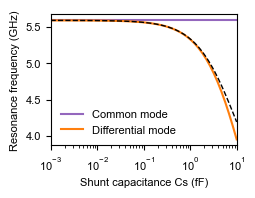

In [30]:
# Note, a factor of pi/2 accounts for the distributed nature of the capacitance to gnd, inductance and shunt capacitance.
params = {"c" : 2 * 20e-15 / np.pi,
          "cdot" : 0.0, 
          "l" : 2 * 100e-9 / np.pi, 
          "omega_e" : 2 * np.pi * 20e9, 
          "alpha_plus_prime" : 0.2e6, 
          "alpha_minus_prime" : -0.2e6}

Cshunt = np.logspace(-18, -14)
f0_comms = np.zeros(len(Cshunt))
f0_diffs = np.zeros(len(Cshunt))

for k, c_s in enumerate(Cshunt):
    params['cdot'] = 2 * c_s / np.pi
    f0_comms[k] = np.sqrt(1 / (params['l'] * (params['c']))) / (2 * np.pi )
    f0_diffs[k] = np.sqrt(1 / (params['l'] * (params['c'] + 2 * params["cdot"]))) / (2 * np.pi )

fig = plt.figure(figsize=(2.4, 1.7))
plt.plot(Cshunt * 1e15, f0_comms / 1e9, color='tab:purple', label='Common mode')
plt.plot(Cshunt * 1e15, f0_diffs / 1e9, color='tab:orange', label='Differential mode')
plt.plot(Cshunt * 1e15, (f0_comms - f0_comms * Cshunt * 2 / np.pi / (params["c"] + 2 * Cshunt * 2  / np.pi)) / 1e9, '--k', lw=1)
plt.xlabel("Shunt capacitance Cs (fF)")
plt.xscale('log')
plt.ylabel("Resonance frequency (GHz)")
plt.legend(loc=0, frameon=False)

plt.xlim(Cshunt.min() * 1e15, Cshunt.max() * 1e15)
ylims = plt.ylim()

# Interesting story: For high impedance you want low capacitance, but you need some capacitance to split the common and differential mode.
# If the shunt cap is much smaller than the total capacitance, alpha << 1, then the splitting is given by alpha * f0 =  cdot * f0 / c + 2 cdot 

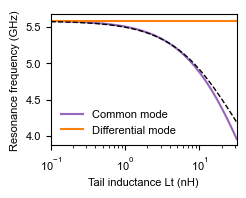

In [31]:
# Note, a factor of pi/2 accounts for the distributed nature of the capacitance to gnd, inductance and shunt capacitance.
params = {"c" : 2 * 20e-15 / np.pi,
          "cdot" : 0.02e-15, 
          "l" : 2 * 100e-9 / np.pi, 
          "omega_e" : 2 * np.pi * 20e9, 
          "alpha_plus_prime" : 0.2e6, 
          "alpha_minus_prime" : -0.2e6}

Ltail = np.logspace(-10, -7.5)
f0_comms = np.zeros(len(Ltail))
f0_diffs = np.zeros(len(Ltail))

for k, l_t in enumerate(Ltail):
    f0_comms[k] = np.sqrt(1 / ((params['l'] + 2 * l_t) * params['c'])) / (2 * np.pi )
    f0_diffs[k] = np.sqrt(1 / (params['l'] * (params['c'] + 2 * params["cdot"]))) / (2 * np.pi )

fig = plt.figure(figsize=(2.4, 1.7))
plt.plot(Ltail * 1e9, f0_comms / 1e9, color='tab:purple', label='Common mode')
plt.plot(Ltail * 1e9, f0_diffs / 1e9, color='tab:orange', label='Differential mode')
plt.plot(Ltail * 1e9, (f0_diffs - f0_diffs * Ltail/ (params["l"] + 2 * Ltail)) / 1e9, '--k', lw=1)
plt.xlabel("Tail inductance Lt (nH)")
plt.xscale('log')
plt.ylabel("Resonance frequency (GHz)")
plt.legend(loc=0, frameon=False)
plt.xlim(Ltail.min() * 1e9, Ltail.max() * 1e9)
plt.ylim(ylims)

In [127]:
def resonator_with_tail(L, Ltail, Ca, Cb, Cs):
    """
    This is only valid if the tail inductance is non-zero
    This method is prefered over the analytical expression, because if the tail is non-zero and the 
    capacitances are asymmetric, the expression becomes very lengthy. Diagonalizing the hamiltonian numerically
    is slightly better.
    """
    L1 = L + 2*Ltail
    L2 = L1
    L3 = L * (L + 2 * Ltail) / Ltail

    D = Ca * Cb + Cs * Ca + Cb * Cs

    Cinv = np.array([[(Cb + Cs) / D, Cs / D], 
                     [Cs / D, (Ca + Cs) / D]])
    
    Linv = np.array([[1 / L2 + 1 / L3,  -1/L3],
                     [-1/L3, 1/L1 + 1/L3]])

    evals, evecs = np.linalg.eig(Linv @ Cinv)
    
    return np.sqrt(np.real(evals)) / (2 * np.pi), evecs

In [245]:
# v3 beta 1 params
mu0 = 4 * np.pi * 1e-7
l = 700e-6
width = 1.6e-6
tail_length = 425e-6
L_sheet = 300e-12

corr_fac_L = 1
corr_fac_C = 1 / corr_fac_L

L = 2 / np.pi * corr_fac_L * (mu0 * l + L_sheet * l / width)
L_tail = 2 / np.pi * corr_fac_L * (mu0 * tail_length + L_sheet * tail_length / width)

Cca = 2 / np.pi * corr_fac_C * (1.49e-15)
Ccb = 2 / np.pi * corr_fac_C * (1.49e-15)
Cunload = 2 / np.pi * corr_fac_C * (3.4e-15)

Ca = 2 / np.pi * corr_fac_C * (14.48e-15) + Cca# + Cunload
Cb = 2 / np.pi * corr_fac_C * (14.48e-15) + Ccb# + Cunload
Cs = 2 / np.pi * corr_fac_C * (2.0e-15)

evals, evecs = resonator_with_tail(L, L_tail, Ca, Cb, Cs)
evals

array([4.86688227e+09, 3.65738421e+09])

In [229]:
evecs

array([[ 0.70710678,  0.70710678],
       [-0.70710678,  0.70710678]])

In [244]:
omega0 = 2 * np.pi * 4.8e9
Z_res = np.sqrt(L / (Ca + 2 * Cs))
Z_0 = 50

Qc1 = 1 / (omega0**2 * Z_res * Z_0 * Cca ** 2)
Qc2 = 1 / (omega0**2 * Z_res * Z_0 * Ccb ** 2)
print(1 / (1/Qc1 + 1/Qc2))

4750.221954899122


In [181]:
Z_res

2698.123477509895

In [198]:
eps_eff = 0.5 * (1 + 11)
w = 1.6e-6
ell = 700e-6
lsh = 220e-12

0.5 * 1 / (2 * np.pi * np.sqrt(lsh * 8.85e-12 * eps_eff)) * (w / ell**3) ** (1/4) / 1e9

6.084683608210375

In [200]:
0.5 * np.sqrt(lsh / (8.85e-12 * eps_eff)) * (ell / w ** 3) ** (1/4)

3679.7524846721

In [270]:
# v3 beta 2 params
mu0 = 4 * np.pi * 1e-7
l = 200e-6
width = 0.2e-6
tail_length = 425e-6
L_sheet = 300e-12

corr_fac_L = 1
corr_fac_C = l / 700e-6

L = 2 / np.pi * corr_fac_L * (mu0 * l + L_sheet * l / width)
L_tail = 2 / np.pi * corr_fac_L * (mu0 * tail_length + L_sheet * tail_length / width)

Cca = 2 / np.pi * corr_fac_C * (1.49e-15)
Ccb = 2 / np.pi * corr_fac_C * (1.49e-15)
Cunload = 2 / np.pi * corr_fac_C * (3.4e-15)

Ca = 2 / np.pi * corr_fac_C * (14.48e-15) + Cca# + Cunload
Cb = 2 / np.pi * corr_fac_C * (14.48e-15) + Ccb# + Cunload
Cs = 2 / np.pi * corr_fac_C * (2.0e-15)

evals, evecs = resonator_with_tail(L, L_tail, Ca, Cb, Cs)
evals

array([6.04007777e+09, 2.94780976e+09])